In [ ]:
from google.colab import drive
drive.mount("/content/drive")


Mounted at /content/drive


In [ ]:
data_path = '/content/drive/MyDrive/Class1'

In [ ]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import img_to_array, load_img
import os
import glob
import imageio.v3 as iio
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.model_selection import KFold
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import img_to_array, load_img
import os
from keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import StratifiedKFold
from keras.applications import ResNet50
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model

In [ ]:
def load_file(file_path, label):
    file_path =file_path

    folder_name = file_path.split("/")[-1]

    out_list = []

    # Load every file .png format
    for image_path in glob.glob(file_path + "/*.PNG"):
        # Read image file
        image = iio.imread(image_path)

        # Declare temporary dict dtype
        temp = {}

        # Set the file name
        temp["name"] = image_path.split("/")[-1]

        # Set the file label, 0 for non defect. 1 for defect
        temp["label"] = label
        # There are somes images are tensor dtype
        # Thus I fix by selecting only a tensor index zero
        try:
            temp["data"] = image[:,:,0].astype("int")
        except:
            # Normal case
            temp["data"] = image.astype("int")

        # Append temp into output list
        out_list.append(temp)

    # Print process status by checking size of output list
    if len(out_list) == 0:
        print("loading files from folder: {} is   failed".format(folder_name))
    else:
        print("loading file from folder: {} is successful".format(folder_name))

    # Convert list into numpy array dtype
    return np.array(out_list)

In [ ]:
pic = data_path + '/defect/0002.PNG'
im = iio.imread(pic)
print('picture shape: {}'.format(im.shape))
print('picture matrix: \n {}'.format(im))
# Set display size


picture shape: (512, 512)
picture matrix: 
 [[ 64  98  66 ...  65  55 133]
 [106 108 148 ...  45  45  55]
 [125 133 196 ...  62  49 122]
 ...
 [ 76  83 104 ...  54  58  56]
 [ 46  56  75 ...  65  66  90]
 [ 96  38  90 ...  90  90 145]]


In [ ]:
defect_images_path = data_path + '/defect'
non_defect_images_path = data_path + '/non-defect'

defect_images = load_file(defect_images_path, 1)
non_defect_images = load_file(non_defect_images_path, 0)

loading file from folder: defect is successful
loading file from folder: non-defect is successful


In [ ]:
import tensorflow as tf
import numpy as np
import os
from keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import StratifiedKFold

def load_file(image_dir, label, image_size=(512, 512)):
    images = []
    for filename in os.listdir(image_dir):
        # Load the image in grayscale mode
        img = load_img(os.path.join(image_dir, filename), color_mode='grayscale', target_size=image_size)
        img_array = img_to_array(img)
        images.append({'data': img_array, 'label': label})
    return np.array(images)

# Load defect and non-defect images
defect_images_path = data_path + '/defect'
non_defect_images_path = data_path + '/non-defect'

defect_images = load_file(defect_images_path, 1)
non_defect_images = load_file(non_defect_images_path, 0)

# Shuffle the images
np.random.shuffle(defect_images)
np.random.shuffle(non_defect_images)

# Balance the classes
#class_size = min(defect_images.shape[0], non_defect_images.shape[0])

# Combine the balanced datasets
dataset = np.concatenate((defect_images, non_defect_images))

# Create an empty matrix X and vector y
X = np.empty([dataset.shape[0], 512, 512, 1]).astype(np.float32)
y = np.empty(dataset.shape[0]).astype(np.int32)

# Assign the data to X and y
for i in range(dataset.shape[0]):
    X[i] = dataset[i]['data']
    y[i] = dataset[i]['label']

# Convert X to a TensorFlow tensor
X = tf.convert_to_tensor(X)

# Convert grayscale images to RGB and resize to (224, 224)
X_rgb = tf.image.grayscale_to_rgb(X)
X_rgb = tf.image.resize(X_rgb, [224, 224])

# Convert back to numpy array for indexing
X_rgb = X_rgb.numpy()

# Display size of the labels
print(np.unique(y, return_counts=True))

<ipython-input-7-04b3ffc7e2ab>:35: RuntimeWarning: invalid value encountered in cast
  y = np.empty(dataset.shape[0]).astype(np.int32)


(array([0, 1], dtype=int32), array([1068,  150]))


In [ ]:
# Define the ResNet50 model
def create_resnet_model(image_shape=(224, 224, 3), print_summary=False):
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=image_shape)

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    predictions = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=base_model.input, outputs=predictions)

    # Freeze the layers in the base model
    for layer in base_model.layers:
        layer.trainable = False

    # Compile the model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Show the CNN model detail
    if print_summary:
        model.summary()

    return model

In [ ]:
# Train the model with StratifiedKFold cross-validation

kfold_splits = 4
n_epoch = 5
batch_size = 10
skf = StratifiedKFold(n_splits=kfold_splits, shuffle=True)

from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

for fold, (train_indices, val_indices) in enumerate(skf.split(X_rgb, y)):
    print(f'Training on fold {fold+1}/{kfold_splits}...')

    # Get the train and validation data for the current fold
    xtrain, xval = X_rgb[train_indices], X_rgb[val_indices]
    ytrain, yval = y[train_indices], y[val_indices]

    # Print number of samples per class in the current fold
    print(f'ytrain: number of samples each class: {np.unique(ytrain, return_counts=True)}')
    print(f'yval: number of samples each class: {np.unique(yval, return_counts=True)}')

    # Create a new model instance
    model = create_resnet_model()

    print(f'Training new iteration on {xtrain.shape[0]} training samples, {xval.shape[0]} validation samples, this may take a while...')

    # Train the model
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    model_checkpoint = tf.keras.callbacks.ModelCheckpoint(f'resnet_model_fold_{fold+1}.h5', save_best_only=True, monitor='val_loss')

    history = model.fit(
        xtrain, ytrain,
        epochs=n_epoch,
        batch_size=batch_size,
        validation_data=(xval, yval),
        callbacks=[early_stopping, model_checkpoint]
    )

    print('— ' * 20)

Training on fold 1/4...
ytrain: number of samples each class: (array([0, 1], dtype=int32), array([801, 112]))
yval: number of samples each class: (array([0, 1], dtype=int32), array([267,  38]))
94765736/94765736 [==============================] - 4s 0us/step
Training new iteration on 913 training samples, 305 validation samples, this may take a while...
Epoch 1/5
92/92 [==============================] - ETA: 0s - loss: 0.5815 - accuracy: 0.8445

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


92/92 [==============================] - 49s 506ms/step - loss: 0.5815 - accuracy: 0.8445 - val_loss: 0.3865 - val_accuracy: 0.8492
Epoch 2/5
92/92 [==============================] - 45s 492ms/step - loss: 0.3124 - accuracy: 0.8762 - val_loss: 0.3389 - val_accuracy: 0.8656
Epoch 3/5
92/92 [==============================] - 52s 572ms/step - loss: 0.2872 - accuracy: 0.8938 - val_loss: 0.3600 - val_accuracy: 0.8623
Epoch 4/5
92/92 [==============================] - 53s 576ms/step - loss: 0.2499 - accuracy: 0.8959 - val_loss: 0.3955 - val_accuracy: 0.8393
Epoch 5/5
92/92 [==============================] - 52s 570ms/step - loss: 0.2088 - accuracy: 0.9179 - val_loss: 0.3131 - val_accuracy: 0.8820
— — — — — — — — — — — — — — — — — — — — 
Training on fold 2/4...
ytrain: number of samples each class: (array([0, 1], dtype=int32), array([801, 112]))
yval: number of samples each class: (array([0, 1], dtype=int32), array([267,  38]))
Training new iteration on 913 training samples, 305 validation sa

Validation Accuracy Average: 0.872595
Validation Loss Average: 0.388525


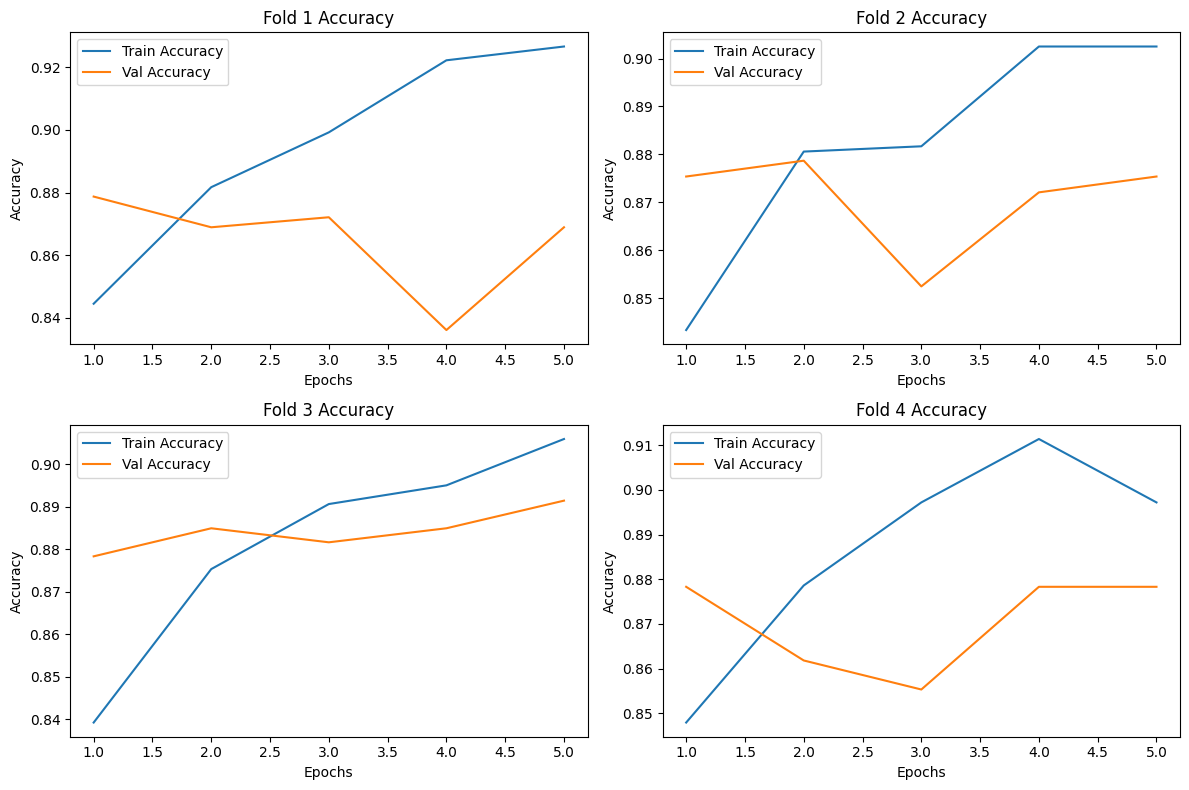

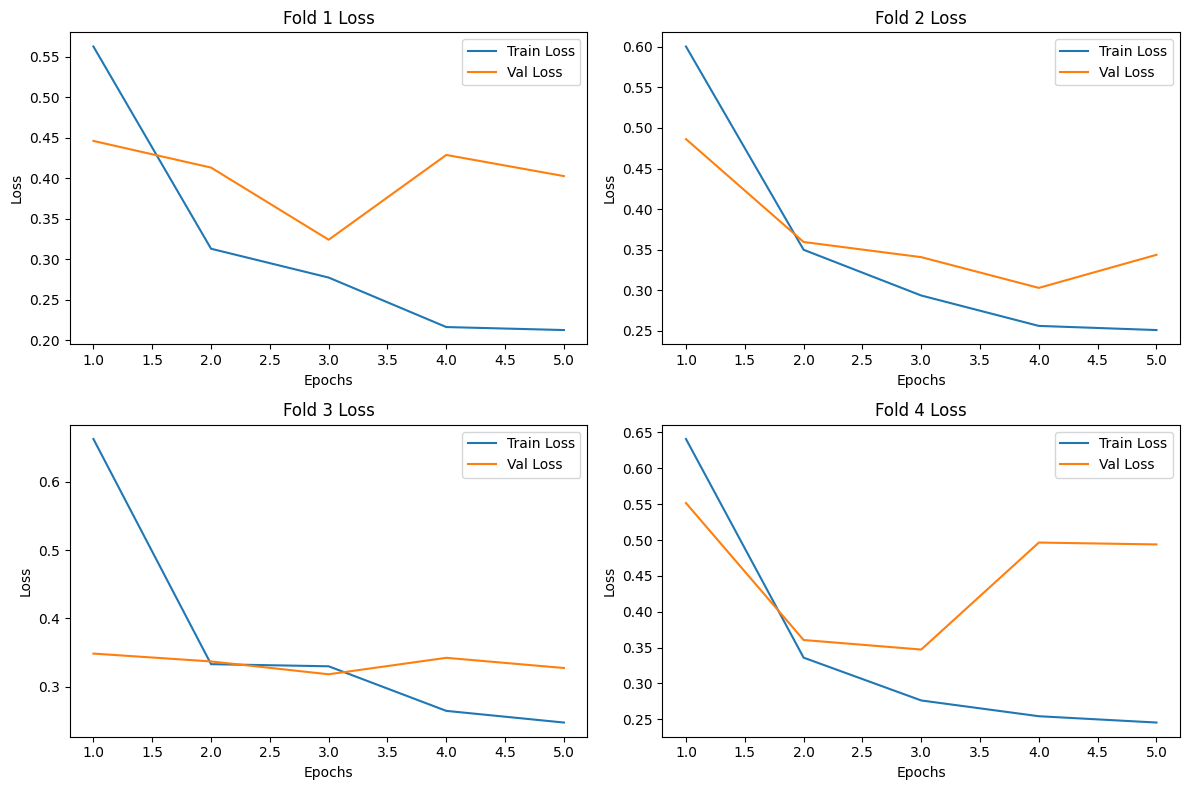

In [ ]:
from matplotlib import pyplot as plt
import numpy as np

# Function to create epochs
def create_epoch(n=0):
    return np.arange(0, n) + 1

# Model evaluation results for each fold
fold1_epoch = create_epoch(n=5)
fold1_loss = np.array([0.5628, 0.3131, 0.2775, 0.2164, 0.2127])
fold1_acc = np.array([0.8445, 0.8817, 0.8992, 0.9222, 0.9266])
fold1_val_loss = np.array([0.4462, 0.4133, 0.3242, 0.4289, 0.4028])
fold1_val_acc = np.array([0.8787, 0.8689, 0.8721, 0.8361, 0.8689])

fold2_epoch = create_epoch(n=5)
fold2_loss = np.array([0.6005, 0.3498, 0.2934, 0.2559, 0.2508])
fold2_acc = np.array([0.8434, 0.8806, 0.8817, 0.9025, 0.9025])
fold2_val_loss = np.array([0.4863, 0.3594, 0.3407, 0.3028, 0.3436])
fold2_val_acc = np.array([0.8754, 0.8787, 0.8525, 0.8721, 0.8754])

fold3_epoch = create_epoch(n=5)
fold3_loss = np.array([0.6626, 0.3328, 0.3297, 0.2644, 0.2473])
fold3_acc = np.array([0.8392, 0.8753, 0.8906, 0.8950, 0.9059])
fold3_val_loss = np.array([0.3483, 0.3368, 0.3180, 0.3421, 0.3272])
fold3_val_acc = np.array([0.8783, 0.8849, 0.8816, 0.8849, 0.8914])

fold4_epoch = create_epoch(n=5)
fold4_loss = np.array([0.6409, 0.3360, 0.2763, 0.2543, 0.2455])
fold4_acc = np.array([0.8479, 0.8786, 0.8972, 0.9114, 0.8972])
fold4_val_loss = np.array([0.5516, 0.3606, 0.3473, 0.4965, 0.4939])
fold4_val_acc = np.array([0.8783, 0.8618, 0.8553, 0.8783, 0.8783])

# Calculate validation averages
val_acc_avg = np.mean([np.mean(fold1_val_acc), np.mean(fold2_val_acc), np.mean(fold3_val_acc), np.mean(fold4_val_acc)])
val_loss_avg = np.mean([np.mean(fold1_val_loss), np.mean(fold2_val_loss), np.mean(fold3_val_loss), np.mean(fold4_val_loss)])

print("Validation Accuracy Average:", val_acc_avg)
print("Validation Loss Average:", val_loss_avg)

# Plot training and validation accuracy for each fold
plt.figure(figsize=(12, 8))

# Fold 1
plt.subplot(2, 2, 1)
plt.plot(fold1_epoch, fold1_acc, label='Train Accuracy')
plt.plot(fold1_epoch, fold1_val_acc, label='Val Accuracy')
plt.title('Fold 1 Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Fold 2
plt.subplot(2, 2, 2)
plt.plot(fold2_epoch, fold2_acc, label='Train Accuracy')
plt.plot(fold2_epoch, fold2_val_acc, label='Val Accuracy')
plt.title('Fold 2 Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Fold 3
plt.subplot(2, 2, 3)
plt.plot(fold3_epoch, fold3_acc, label='Train Accuracy')
plt.plot(fold3_epoch, fold3_val_acc, label='Val Accuracy')
plt.title('Fold 3 Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Fold 4
plt.subplot(2, 2, 4)
plt.plot(fold4_epoch, fold4_acc, label='Train Accuracy')
plt.plot(fold4_epoch, fold4_val_acc, label='Val Accuracy')
plt.title('Fold 4 Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Plot training and validation loss for each fold
plt.figure(figsize=(12, 8))

# Fold 1
plt.subplot(2, 2, 1)
plt.plot(fold1_epoch, fold1_loss, label='Train Loss')
plt.plot(fold1_epoch, fold1_val_loss, label='Val Loss')
plt.title('Fold 1 Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Fold 2
plt.subplot(2, 2, 2)
plt.plot(fold2_epoch, fold2_loss, label='Train Loss')
plt.plot(fold2_epoch, fold2_val_loss, label='Val Loss')
plt.title('Fold 2 Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Fold 3
plt.subplot(2, 2, 3)
plt.plot(fold3_epoch, fold3_loss, label='Train Loss')
plt.plot(fold3_epoch, fold3_val_loss, label='Val Loss')
plt.title('Fold 3 Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Fold 4
plt.subplot(2, 2, 4)
plt.plot(fold4_epoch, fold4_loss, label='Train Loss')
plt.plot(fold4_epoch, fold4_val_loss, label='Val Loss')
plt.title('Fold 4 Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()
